## Основная идея и принцип работы

Код реализует систему прогнозирования цен криптовалют, основанную на поиске исторических паттернов с похожими фрактальными характеристиками. Основная гипотеза: если в истории находятся участки графика, похожие на текущий по своим статистическим и фрактальным свойствам, то их дальнейшее развитие может подсказать вероятное движение цены в будущем

## Пошаговый алгоритм работы
### Шаг 1: Сбор данных
* Загружается история
* Данные включают: цены открытия/закрытия, максимум/минимум, объем торгов
* Временной интервал настраивается (по умолчанию 4 часа)

### Шаг 2: Выделение текущего паттерна
* Берутся последние N свечей (по умолчанию 500)
* Это и есть "текущий паттерн", для которого ищутся аналоги в истории

### Шаг 3: Расчет характеристик текущего паттерна
#### Для паттерна вычисляются три ключевые метрики:
* a) Тренд (Trend), Trend = (Price_last - Price_first) / Price_first. Показывает общее направление и силу движения цены
* b) Волатильность (Volatility), Volatility = StandardDeviation(Price_changes), где Price_changes = (Price[i] - Price[i-1]) / Price[i-1]. Измеряет изменчивость цены
* c) Фрактальная размерность (Fractal Dimension). Использует метод "box-counting":
* * Нормализация цен в диапазон [0,1]:
* * Normalized_price = (Price - Min_price) / (Max_price - Min_price)

* Разбиение временного ряда на "коробки" разного размера (scale)
* Подсчет количества коробок, содержащих часть графика:

* * Для каждого масштаба scale от 2 до n/4:
* * Делим ряд на boxes = n/scale участков
* * Считаем, сколько участков содержат изменение цены > 0


#### Расчет фрактальной размерности:
* log(Count) = -D * log(Scale) + C, где D - фрактальная размерность (наклон линии регрессии), где:
* Count - количество "заполненных" коробок
* Scale - размер коробки (масштаб разбиения)
* C - свободный член (константа). Это точка пересечения линии регрессии с осью Y в логарифмических координатах
#### Фрактальная размерность показывает "изрезанность" графика:
* D ≈ 1.0 - гладкий тренд
* D ≈ 1.5 - типичный финансовый ряд
* D ≈ 2.0 - очень хаотичное движение

### Шаг 4: Поиск похожих паттернов в истории
* Алгоритм сканирует всю историю, выделяя участки той же длины и вычисляя для каждого:
* * Тренд
* * Волатильность
* * Фрактальную размерность

### Шаг 5: Расчет схожести паттернов
* Для каждого исторического паттерна вычисляется схожесть с текущим: Similarity = Σ(Weight[i] / (1 + |Feature_current[i] - Feature_historical[i]|)) / Σ(Weight[i]), где:
* * Feature[i] - значения тренда, волатильности и фрактальной размерности
* * Weight[i] - веса важности каждой характеристики (по умолчанию все равны 1.0)

Паттерны с Similarity > 0.9 считаются достаточно похожими

### Шаг 6: Генерация прогноза
Выбираются TOP-5 самых похожих исторических паттернов. Для каждого берется участок, следующий за паттерном (250 свечей вперед).

#### Взвешенное усреднение:
* Prediction = Σ(Future_prices[i] * Similarity[i]) / Σ(Similarity[i])

#### При этом исторические цены нормализуются к текущему уровню:
* Normalized_future = Historical_future * (Current_last_price / Historical_last_price)
* Доверительный интервал:
* * Upper_bound = Prediction + 1.5 * StandardDeviation(All_predictions)
* * Lower_bound = Prediction - 1.5 * StandardDeviation(All_predictions)

### Шаг 7: Визуализация
* Создается график с:
* * Свечным графиком текущего паттерна
* * Линией прогноза с доверительным интервалом
* * Индикатором схожести найденных паттернов
* * Графиком объемов торгов

#### Особые случаи
* Если похожих паттернов не найдено (все Similarity < 0.9):
* * Используется простая линейная экстраполяция последних 20 свечей
* * Схожесть устанавливается в 0.3 (30%)
* * Доверительный интервал ±2%

=== Фрактальный предиктор паттернов ===
Торговая пара: BTCUSDT
Интервал: 4h
Размер паттерна: 200 свечей
Прогноз на: 100 свечей
Обновление каждые: 300 секунд
Инициализация...

Запуск анализа с обновлением каждые 300 секунд...
Нажмите Ctrl+C для остановки


[2025-06-26 13:57:06] Обновление анализа...


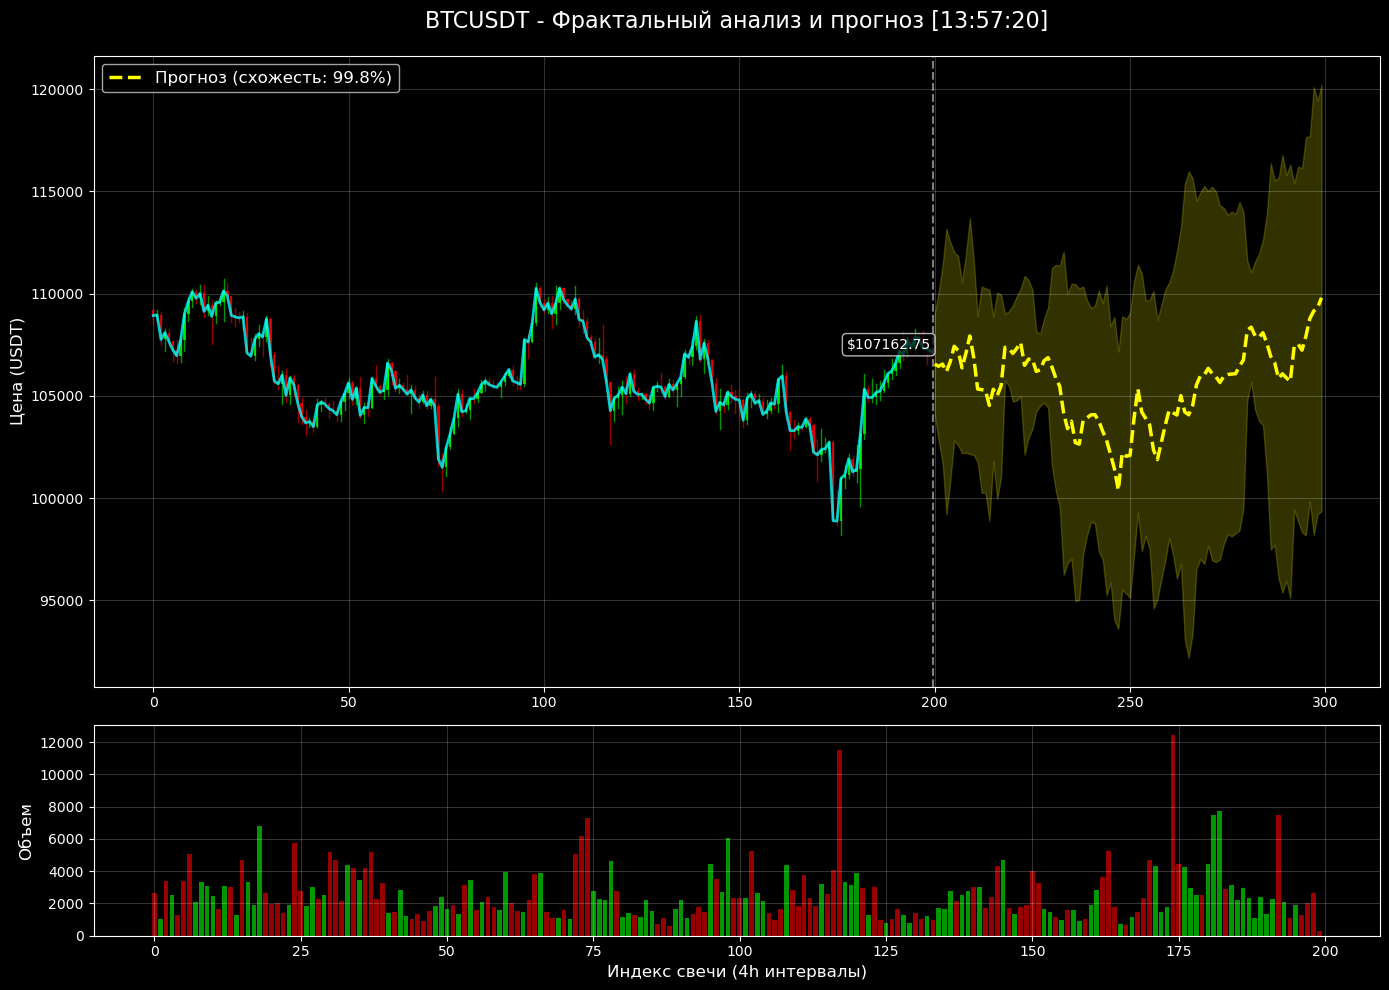

Схожесть с историческими паттернами: 99.8%
Текущая цена: $107162.75
Прогноз через 50 свечей: $109798.78
Изменение: 2.46%

Следующее обновление через 300 секунд...
Осталось 300 секунд...

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import requests
from datetime import datetime, timedelta
import time
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# ==================== НАСТРОЙКИ ====================
# Торговая пара
SYMBOL = 'BTCUSDT'

# Временной интервал (1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M)
INTERVAL = '4h'

# Размер окна для анализа (количество свечей для поиска паттернов)
WINDOW_SIZE = 500

# Размер текущего паттерна для анализа (последние N свечей)
PATTERN_SIZE = 200

# Количество свечей для предсказания в будущее
PREDICTION_SIZE = 100

# Интервал обновления в секундах (300 = 5 минут)
UPDATE_INTERVAL = 300

# Количество исторических данных для загрузки с API
DATA_LIMIT = 10000

# Минимальный порог схожести паттернов (0.0 - 1.0)
SIMILARITY_THRESHOLD = 0.9

# Количество лучших паттернов для усреднения
TOP_PATTERNS = 5

# Множитель для доверительного интервала
CONFIDENCE_MULTIPLIER = 1.5

# Визуальные настройки
FIGURE_SIZE = (14, 10)  # Размер графика
CANDLE_WIDTH = 0.6      # Ширина свечей
GRID_ALPHA = 0.2        # Прозрачность сетки
COLOR_BULLISH = '#00ff00'  # Цвет растущих свечей
COLOR_BEARISH = '#ff0000'  # Цвет падающих свечей
COLOR_CURRENT_LINE = 'cyan'  # Цвет линии текущей цены
COLOR_PREDICTION = 'yellow'  # Цвет линии предсказания
STYLE_THEME = 'dark_background'  # Тема графика

# API настройки
BINANCE_API_URL = 'https://api.binance.com/api/v3/klines'
REQUEST_TIMEOUT = 10  # Таймаут запроса в секундах

# Настройки фрактального анализа
MIN_SCALE = 2           # Минимальный масштаб для box-counting
MAX_SCALE_FACTOR = 4    # Делитель для максимального масштаба (n//MAX_SCALE_FACTOR)
DEFAULT_FRACTAL_DIM = 1.5  # Фрактальная размерность по умолчанию

# Веса для расчета схожести паттернов
SIMILARITY_WEIGHTS = {
    'trend': 1.0,
    'volatility': 1.0,
    'fractal_dim': 1.0
}
# ==================== КОНЕЦ НАСТРОЕК ====================

class FractalPatternPredictor:
    def __init__(self, symbol=SYMBOL, interval=INTERVAL, window_size=WINDOW_SIZE, 
                 pattern_size=PATTERN_SIZE, prediction_size=PREDICTION_SIZE):
        """
        Инициализация предиктора фрактальных паттернов
        """
        self.symbol = symbol
        self.interval = interval
        self.window_size = window_size
        self.pattern_size = pattern_size
        self.prediction_size = prediction_size
        self.scaler = MinMaxScaler()
        
        # Хранилище данных
        self.current_data = None
        self.current_pattern = None
        self.prediction = None
        self.similarity_score = 0
        
    def get_live_data(self):
        """
        Получение данных с Binance API
        """
        url = BINANCE_API_URL
        params = {
            'symbol': self.symbol,
            'interval': self.interval,
            'limit': DATA_LIMIT
        }
        
        try:
            response = requests.get(url, params=params, timeout=REQUEST_TIMEOUT)
            data = response.json()
            
            df = pd.DataFrame(data, columns=[
                'timestamp', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'trades', 'taker_buy_base',
                'taker_buy_quote', 'ignore'
            ])
            
            for col in ['open', 'high', 'low', 'close', 'volume']:
                df[col] = df[col].astype(float)
            
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            
            return df
        except Exception as e:
            print(f"Ошибка получения данных: {e}")
            return None
    
    def calculate_fractal_dimension(self, prices):
        """
        Расчет фрактальной размерности
        """
        n = len(prices)
        if n < 10:
            return DEFAULT_FRACTAL_DIM
            
        scales = []
        counts = []
        
        # Нормализация
        price_range = np.max(prices) - np.min(prices)
        if price_range == 0:
            return DEFAULT_FRACTAL_DIM
            
        normalized_prices = (prices - np.min(prices)) / price_range
        
        for scale in range(MIN_SCALE, min(n//MAX_SCALE_FACTOR, 20)):
            boxes = n // scale
            count = 0
            
            for i in range(boxes):
                segment = normalized_prices[i*scale:(i+1)*scale]
                if len(segment) > 0 and np.max(segment) - np.min(segment) > 0:
                    count += 1
            
            if count > 0:
                scales.append(scale)
                counts.append(count)
        
        if len(scales) > 1:
            log_scales = np.log(scales)
            log_counts = np.log(counts)
            coeffs = np.polyfit(log_scales, log_counts, 1)
            return -coeffs[0]
        
        return DEFAULT_FRACTAL_DIM
    
    def find_similar_patterns(self, data, current_pattern):
        """
        Поиск похожих паттернов в данных
        """
        pattern_length = len(current_pattern)
        similar_patterns = []
        
        # Извлекаем характеристики текущего паттерна
        current_features = {
            'trend': (current_pattern['close'].iloc[-1] - current_pattern['close'].iloc[0]) / current_pattern['close'].iloc[0],
            'volatility': current_pattern['close'].pct_change().std(),
            'fractal_dim': self.calculate_fractal_dimension(current_pattern['close'].values)
        }
        
        # Сканируем исторические данные
        for i in range(len(data) - pattern_length - self.prediction_size - 10):
            historical_pattern = data.iloc[i:i+pattern_length]
            
            # Характеристики исторического паттерна
            hist_features = {
                'trend': (historical_pattern['close'].iloc[-1] - historical_pattern['close'].iloc[0]) / historical_pattern['close'].iloc[0],
                'volatility': historical_pattern['close'].pct_change().std(),
                'fractal_dim': self.calculate_fractal_dimension(historical_pattern['close'].values)
            }
            
            # Расчет схожести
            similarity = 0
            for key in current_features:
                if hist_features[key] != 0 and key in SIMILARITY_WEIGHTS:
                    diff = abs(current_features[key] - hist_features[key])
                    similarity += SIMILARITY_WEIGHTS[key] / (1 + diff)
            
            total_weight = sum(SIMILARITY_WEIGHTS.values())
            similarity = similarity / total_weight
            
            if similarity > SIMILARITY_THRESHOLD:  # Порог схожести
                future_data = data.iloc[i+pattern_length:i+pattern_length+self.prediction_size]
                if len(future_data) == self.prediction_size:
                    similar_patterns.append({
                        'pattern': historical_pattern,
                        'future': future_data,
                        'similarity': similarity
                    })
        
        return sorted(similar_patterns, key=lambda x: x['similarity'], reverse=True)[:TOP_PATTERNS]
    
    def generate_prediction(self):
        """
        Генерация предсказания на основе текущих данных
        """
        # Получаем данные
        data = self.get_live_data()
        if data is None or len(data) < self.window_size:
            print("Недостаточно данных")
            return None
        
        self.current_data = data
        self.current_pattern = data.iloc[-self.pattern_size:]
        
        # Ищем похожие паттерны
        similar_patterns = self.find_similar_patterns(data, self.current_pattern)
        
        if len(similar_patterns) == 0:
            # Если похожих паттернов нет, используем простую экстраполяцию
            last_prices = self.current_pattern['close'].tail(20).values
            trend = np.polyfit(range(len(last_prices)), last_prices, 1)[0]
            
            last_price = self.current_pattern['close'].iloc[-1]
            self.prediction = []
            for i in range(self.prediction_size):
                next_price = last_price + trend * i * 0.1
                self.prediction.append(next_price)
            
            self.similarity_score = 0.3
            self.confidence_upper = np.array(self.prediction) * (1 + 0.02)
            self.confidence_lower = np.array(self.prediction) * (1 - 0.02)
        else:
            # Усредняем предсказания от похожих паттернов
            predictions = []
            weights = []
            
            for pattern_info in similar_patterns:
                future_prices = pattern_info['future']['close'].values
                # Нормализуем к текущей цене
                normalized_future = future_prices * (self.current_pattern['close'].iloc[-1] / pattern_info['pattern']['close'].iloc[-1])
                predictions.append(normalized_future)
                weights.append(pattern_info['similarity'])
            
            weights = np.array(weights) / np.sum(weights)
            self.prediction = np.average(predictions, axis=0, weights=weights)
            self.similarity_score = np.mean([p['similarity'] for p in similar_patterns])
            
            # Доверительный интервал
            std_pred = np.std(predictions, axis=0)
            self.confidence_upper = self.prediction + CONFIDENCE_MULTIPLIER * std_pred
            self.confidence_lower = self.prediction - CONFIDENCE_MULTIPLIER * std_pred
        
        return self.prediction
    
    def plot_current_state(self):
        """
        Создание графика текущего состояния и предсказания
        """
        if self.current_pattern is None or self.prediction is None:
            return None
        
        plt.style.use(STYLE_THEME)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=FIGURE_SIZE, 
                                       gridspec_kw={'height_ratios': [3, 1]})
        
        # Подготовка данных
        pattern_data = self.current_pattern
        pattern_index = range(len(pattern_data))
        
        # График свечей для текущего паттерна
        for i in range(len(pattern_data)):
            row = pattern_data.iloc[i]
            color = COLOR_BULLISH if row['close'] > row['open'] else COLOR_BEARISH
            # Тело свечи
            height = abs(row['close'] - row['open'])
            bottom = min(row['close'], row['open'])
            ax1.bar(i, height, bottom=bottom, width=CANDLE_WIDTH, color=color, alpha=0.8)
            # Тени
            ax1.plot([i, i], [row['low'], row['high']], color=color, linewidth=1, alpha=0.6)
        
        # Линия закрытия
        ax1.plot(pattern_index, pattern_data['close'].values, COLOR_CURRENT_LINE, linewidth=2, alpha=0.8)
        
        # Предсказание
        pred_index = range(len(pattern_data), len(pattern_data) + len(self.prediction))
        ax1.plot(pred_index, self.prediction, COLOR_PREDICTION, linewidth=2.5, linestyle='--', 
                label=f'Прогноз (схожесть: {self.similarity_score:.1%})')
        
        # Доверительный интервал
        ax1.fill_between(pred_index, self.confidence_lower, self.confidence_upper, 
                        color=COLOR_PREDICTION, alpha=0.2)
        
        # Разделительная линия
        ax1.axvline(x=len(pattern_data)-0.5, color='white', linestyle='--', alpha=0.5)
        
        # Настройки графика
        ax1.set_title(f'{self.symbol} - Фрактальный анализ и прогноз [{datetime.now().strftime("%H:%M:%S")}]', 
                     fontsize=16, pad=20)
        ax1.set_ylabel('Цена (USDT)', fontsize=12)
        ax1.legend(loc='upper left', fontsize=12)
        ax1.grid(True, alpha=GRID_ALPHA)
        
        # Добавим текущую цену
        current_price = pattern_data['close'].iloc[-1]
        ax1.text(len(pattern_data)-1, current_price, f'${current_price:.2f}', 
                ha='right', va='bottom', fontsize=10, color='white', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
        
        # График объемов
        volumes = pattern_data['volume'].values
        colors = [COLOR_BULLISH if pattern_data['close'].iloc[i] > pattern_data['open'].iloc[i] 
                 else COLOR_BEARISH for i in range(len(volumes))]
        ax2.bar(pattern_index, volumes, color=colors, alpha=0.6)
        ax2.set_ylabel('Объем', fontsize=12)
        ax2.set_xlabel(f'Индекс свечи ({self.interval} интервалы)', fontsize=12)
        ax2.grid(True, alpha=GRID_ALPHA)
        
        plt.tight_layout()
        return fig
    
    def run_continuous_prediction(self):
        """
        Непрерывное обновление предсказаний каждые 5 минут
        """
        plt.ion()  # Интерактивный режим
        
        while True:
            try:
                print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Обновление анализа...")
                
                # Генерируем предсказание
                prediction = self.generate_prediction()
                
                if prediction is not None:
                    # Очищаем предыдущий график
                    plt.close('all')
                    
                    # Создаем новый график
                    fig = self.plot_current_state()
                    if fig:
                        plt.show()
                        print(f"Схожесть с историческими паттернами: {self.similarity_score:.1%}")
                        print(f"Текущая цена: ${self.current_pattern['close'].iloc[-1]:.2f}")
                        print(f"Прогноз через 50 свечей: ${self.prediction[-1]:.2f}")
                        print(f"Изменение: {((self.prediction[-1] / self.current_pattern['close'].iloc[-1]) - 1) * 100:.2f}%")
                
                # Ждем указанное время
                print(f"\nСледующее обновление через {UPDATE_INTERVAL} секунд...")
                for i in range(UPDATE_INTERVAL, 0, -30):
                    print(f"\rОсталось {i} секунд...", end='')
                    time.sleep(min(30, i))
                
            except KeyboardInterrupt:
                print("\n\nОстановка анализа...")
                break
            except Exception as e:
                print(f"\nОшибка: {e}")
                print("Повтор через 1 минуту...")
                time.sleep(60)


def main():
    print("=== Фрактальный предиктор паттернов ===")
    print(f"Торговая пара: {SYMBOL}")
    print(f"Интервал: {INTERVAL}")
    print(f"Размер паттерна: {PATTERN_SIZE} свечей")
    print(f"Прогноз на: {PREDICTION_SIZE} свечей")
    print(f"Обновление каждые: {UPDATE_INTERVAL} секунд")
    print("=" * 40)
    print("Инициализация...")
    
    # Создаем предиктор
    predictor = FractalPatternPredictor()
    
    # Запускаем непрерывное предсказание
    print(f"\nЗапуск анализа с обновлением каждые {UPDATE_INTERVAL} секунд...")
    print("Нажмите Ctrl+C для остановки\n")
    
    predictor.run_continuous_prediction()


if __name__ == "__main__":
    main()